In [1]:
import pickle
import gzip
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from PIL import Image
import os
import numpy as np
np.random.seed(666)

In [2]:
filename = '../mnist.pkl.gz'
f = gzip.open(filename, 'rb')
training_data, validation_data, test_data = pickle.load(f, encoding='latin1')
f.close()

In [3]:
# Functions
def one_hot_vect(tuple_data,classes):
    one_hot_encoded=np.zeros((len(tuple_data[1]),len(classes)))
    identity = np.identity(len(classes))
    for i in range(len(tuple_data[1])):
        one_hot_encoded[i] = np.add(one_hot_encoded[i],identity[tuple_data[1][i]])
    return one_hot_encoded

def softmax(weights,train_data):
    bias = np.ones((np.shape(train_data)[0],1))
    train_withBias = np.hstack((train_data,bias))
    num = np.dot(weights,train_withBias.T)
    # High value Fix
    # https://houxianxu.github.io/2015/04/23/logistic-softmax-regression/
    num = np.subtract(num,np.max(num,axis=0))
    num = np.exp(num)
    # Fix softmax when using batch size 1 the dimension of deno changes
    if(len(train_data) == 1):
        deno = np.sum(num,axis=0)
    else:
        deno = np.sum(num,axis=1)
        deno = deno.reshape((10,1))
    return np.divide(num,deno)

def cross_entropy_error(predicted,target):
    right = np.log(predicted)
    loss = np.multiply(np.matrix(target),np.transpose(np.matrix(right)))
    return -np.sum(np.sum(loss,axis=1),axis=0)

def batch_gradient(predicted,train_data,target):
    leftleft = np.transpose(predicted)
    left = np.subtract(leftleft,target)
    bias = np.ones((np.shape(train_data)[0],1))
    train_withBias = np.hstack((train_data,bias))
    gradient = np.dot(left.T,train_withBias)
    gradient = gradient/len(train_data)
    return np.matrix(gradient,dtype="float64")

def accuracy(predicted,target):
    correct = 0
    left = np.array(np.argmax(predicted,axis=0)).flatten()
    right = np.argmax(target,axis=1)
    confusion_mat = np.zeros((len(np.unique(right)),len(np.unique(left))))
    for i in range(len(target)):
        if(left[i] == right[i]):
            correct+=1
        confusion_mat[left[i]][right[i]] =confusion_mat[left[i]][right[i]] +1
    return correct/len(target),pd.DataFrame(np.matrix(confusion_mat,dtype="int32"))

def more_metrics(conf_mat):
    true_positives = 0
    precision = []
    recall = []
    for i in range(len(conf_mat)):
        true_positives += conf_mat.iloc[i,i]
    conf_mat = np.matrix(conf_mat)
    tp_fp = np.array(np.sum(conf_mat,axis=1)).ravel()
    relevant_elements = np.array(np.sum(conf_mat,axis=0)).ravel()
    for i in range(len(conf_mat)):
        precision.append(conf_mat[i,i]/tp_fp[i])
        recall.append(conf_mat[i,i]/relevant_elements[i])
    return true_positives,precision,recall

def epoch_shuffle(processed_train_data,target):
    # Merge
    trainDF = pd.DataFrame(processed_train_data)
    targetDF = pd.DataFrame(target)
    result = pd.concat([trainDF.reset_index(),targetDF.reset_index()],join='inner',axis=1)
    result = result.sample(frac=1)
    
    return np.asarray(result.iloc[:,1:np.shape(trainDF)[1]+1]),np.asarray(result.iloc[:,np.shape(trainDF)[1]+2:])

In [4]:
# Fixed Var
classes = np.unique(training_data[1])
weights = np.random.randn(len(classes), np.shape(training_data[0])[1]+1) * 0.001
train_data = training_data[0]

In [5]:
target = one_hot_vect(training_data,classes)
target_val = one_hot_vect(validation_data,classes)
target_test = one_hot_vect(test_data,classes)
scaler = StandardScaler()
scaler.fit(train_data)
scaler.fit(validation_data[0])
scaler.fit(test_data[0])
processed_train_data = scaler.transform(train_data)
processed_val_data = scaler.transform(validation_data[0])
processed_test_data = scaler.transform(test_data[0])
predicted = softmax(weights,processed_train_data)

In [47]:
batchSize = 500
start = 0
end = batchSize
batches = len(processed_train_data)/batchSize
weights = np.random.randn(len(classes), np.shape(training_data[0])[1]+1) * 0.001
predicted = softmax(weights,processed_train_data[start:end,:])
cost_initial = np.asscalar(cross_entropy_error(softmax(weights,processed_train_data),target))
cost_new = cost_initial*10
training_loss =[]
val_loss=[]
i=1
logging=True
while(i<batches):
        print("Percentage Done: "+str(i/batches))
        new_weights = batch_gradient(predicted,processed_train_data[start:end,:],target[start:end,:])
        weights = weights - 0.0003*new_weights
        if(logging and i%1==0):
            # Predict Train & Validation for these weights
            predict_val = softmax(weights,processed_val_data)
            # Calculate cost of predicting Validation and Training, To see if the hyper param are working
            acc,_  = accuracy(predict_val,target_val)
            val_loss.append(acc)
            predict_train = softmax(weights,processed_train_data)
            acc,_  = accuracy(predict_train,target)
            training_loss.append(acc)
        #print("Training Loss: "+str(cost))
        start = start + batchSize
        end = end + batchSize
        # New Prediction for the data
        predicted = softmax(weights,processed_train_data[start:end,:])
        if(not logging):
            cost = np.asscalar(cross_entropy_error(predicted,target[start:end,:]))
            print("Cost of Batch: "+str(cost))
        i = i+1

Percentage Done: 0.01
Percentage Done: 0.02
Percentage Done: 0.03
Percentage Done: 0.04
Percentage Done: 0.05
Percentage Done: 0.06
Percentage Done: 0.07
Percentage Done: 0.08
Percentage Done: 0.09
Percentage Done: 0.1
Percentage Done: 0.11
Percentage Done: 0.12
Percentage Done: 0.13
Percentage Done: 0.14
Percentage Done: 0.15
Percentage Done: 0.16
Percentage Done: 0.17
Percentage Done: 0.18
Percentage Done: 0.19
Percentage Done: 0.2
Percentage Done: 0.21
Percentage Done: 0.22
Percentage Done: 0.23
Percentage Done: 0.24
Percentage Done: 0.25
Percentage Done: 0.26
Percentage Done: 0.27
Percentage Done: 0.28
Percentage Done: 0.29
Percentage Done: 0.3
Percentage Done: 0.31
Percentage Done: 0.32
Percentage Done: 0.33
Percentage Done: 0.34
Percentage Done: 0.35
Percentage Done: 0.36
Percentage Done: 0.37
Percentage Done: 0.38
Percentage Done: 0.39
Percentage Done: 0.4
Percentage Done: 0.41
Percentage Done: 0.42
Percentage Done: 0.43
Percentage Done: 0.44
Percentage Done: 0.45
Percentage Don

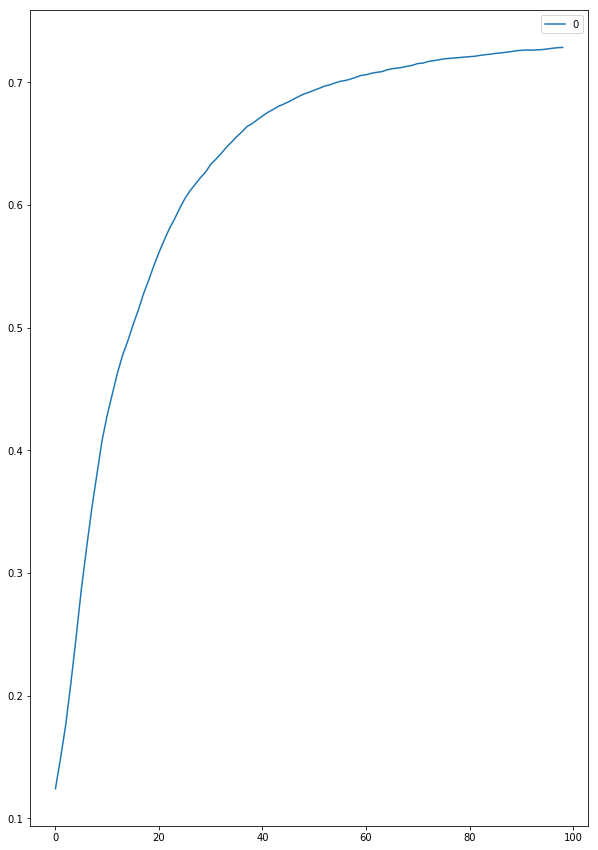

In [48]:
df = pd.DataFrame(training_loss)
ax = df.plot(figsize=(10,15))
ax.ticklabel_format(useOffset=False)
plt.savefig('./train_loss.png',bbox_inches='tight')
plt.show(ax)

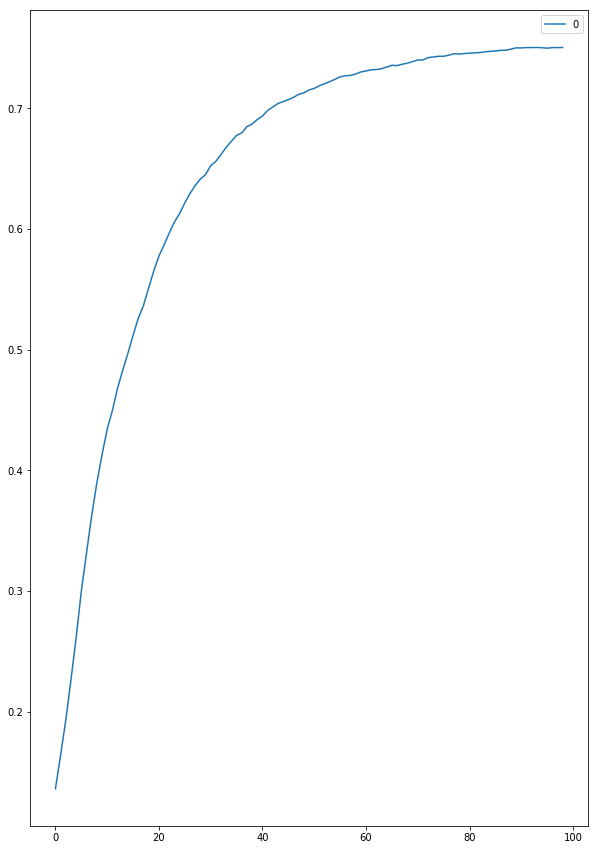

In [49]:
df = pd.DataFrame(val_loss)
ax = df.plot(figsize=(10,15))
ax.ticklabel_format(useOffset=False)
plt.savefig('./val_loss.png',bbox_inches='tight')
plt.show(ax)

In [50]:
predict_val = softmax(weights,processed_val_data)
accuracy(predict_val,target_val)

(0.7504,      0     1    2    3    4    5    6    7    8    9
 0  920     0   67   41   47  114   67   22   48   26
 1    4  1051   75   85  100  139   44   92  233   67
 2    2     4  735   34   13   16   15    4   28    4
 3    5     2   16  786    0  127    0    6   67   12
 4    1     1    4    1  697   10    1    8    6   96
 5    6     0    0    5    1  416    7    0   36    1
 6   40     5   56    7   25   32  833    1    8    0
 7    3     1   16   25    5   17    0  947   26  159
 8    6     0   18   34    1   10    0    0  523    0
 9    4     0    3   12   94   34    0   10   34  596)

In [51]:
predict_test = softmax(weights,processed_test_data)
accuracy(predict_test,target_test)

(0.7453,      0     1    2    3    4    5    6    7    8    9
 0  933     0   81   39   39   87  113    8   74   41
 1    2  1127  107   94   95  127   33   95  159   63
 2    0     2  718   28   12   11   11   14   15    8
 3    7     3   20  766    1  132    1    5   86   13
 4    0     0    6    0  704   16    5    4   16  116
 5    7     0    0    6    0  424   15    0   33    0
 6   27     3   52   11   40   28  780    1   18    3
 7    3     0   22   41   13   34    0  883   33  146
 8    1     0   26   19    2   11    0    3  502    3
 9    0     0    0    6   76   22    0   15   38  616)

In [18]:
true_positives,precision,recall = more_metrics(conf_mat)

NameError: name 'conf_mat' is not defined

In [33]:
predict_test = softmax(weights,processed_train_data)
accuracy(predict_test,target)

(0.90468,       0     1     2     3     4     5     6     7     8     9
 0  4745     1    30    17     9    79    47    21    43    34
 1     1  5433    36    36    21    39    12    32   108    24
 2    33    40  4409   155    33    38    28    63    77    22
 3    12    22   170  4456     3   127     6    21   120    36
 4     8    11    55    12  4434    54    24    51    50   195
 5    27    23    23   181    10  3889   111    18   187    56
 6    41     2    83    10    80    57  4692     2    41     3
 7     7    16    66    79    18    24     2  4761    20   250
 8    48   125    85    98    65   165    26    19  4105    58
 9    10     5    11    57   186    34     3   187    91  4310)

# USPS Data Test

In [39]:
USPSMat  = []
USPSTar  = []
curPath  = '../USPSdata/Numerals'
savedImg = []

for j in range(0,10):
    curFolderPath = curPath + '/' + str(j)
    imgs =  os.listdir(curFolderPath)
    for img in imgs:
        curImg = curFolderPath + '/' + img
        if curImg[-3:] == 'png':
            img = Image.open(curImg,'r')
            img = img.resize((28, 28))
            savedImg = img
            imgdata = (255-np.array(img.getdata()))/255
            USPSMat.append(imgdata)
            USPSTar.append(j)

In [40]:
target_USPS = one_hot_vect((1,USPSTar),classes)
scaler.fit(USPSMat)
processed_USPSDat = scaler.transform(USPSMat)


In [52]:
predict_USPS = softmax(weights,processed_USPSDat)
accuracy(predict_USPS,target_USPS)

(0.24386219310965548,      0    1    2    3    4    5    6     7    8    9
 0  805  173  381  428  281  315  776   121  334  137
 1   72  972  367   83  398  319   85  1034  329  405
 2  162  158  515  177   42  195  232    35   69  120
 3   12   66   76  663   17  293   47   199  383  222
 4  190  255   45   17  713   14   30    71  104  117
 5   17   42   50  167   55  243   55    36  100   23
 6  343   86  342  161   92  357  408   117  292   44
 7  168  151   82  101  224   97  295   272  128  726
 8    9   37  115  101   39   64   23    90  204  124
 9  222   60   26  102  139  103   49    25   57   82)

In [37]:
predict_USPS

matrix([[5.37503408e-06, 3.69834962e-07, 2.79342750e-06, ...,
         1.70547558e-05, 1.76974197e-07, 1.87009545e-04],
        [3.37966925e-06, 1.07965933e-07, 3.25091099e-07, ...,
         9.24967841e-05, 3.95829284e-07, 7.08793064e-06],
        [7.26833205e-06, 5.04313666e-07, 1.78261529e-06, ...,
         8.34814537e-05, 4.30276090e-07, 7.55579221e-06],
        ...,
        [2.62365956e-05, 2.03227730e-06, 2.22502579e-06, ...,
         2.48036457e-04, 1.45435313e-04, 1.30467584e-04],
        [3.92569968e-06, 1.89821420e-06, 8.30071770e-07, ...,
         2.59259738e-04, 1.39723249e-07, 2.70461446e-05],
        [7.28843744e-06, 3.17793972e-07, 5.65148371e-07, ...,
         1.14518824e-05, 3.49620059e-06, 5.05272703e-06]])